In [1]:
from pathlib import Path
from typing import Optional

import janitor
import pandas as pd
import plotnine as gg
import seaborn as sns

%config InlineBackend.figure_format='retina'

In [2]:
benchmark_dir = Path("../benchmarks/")
assert benchmark_dir.exists()
assert benchmark_dir.is_dir()

## Data Processing

Organization of benchmarks directory:

1. pipeline
2. rules
3. individual runs

> I may want to add more information to the name of the rules to keep them separate and not overwritten.
> For instance, including the date would be useful or metadata such as the data size for SBC or debug status for the fitting pipeline.

In [3]:
list(benchmark_dir.iterdir())

[PosixPath('../benchmarks/010_010_run-crc-sampling-snakemake'),
 PosixPath('../benchmarks/012_010_simulation-based-calibration-snakemake')]

In [4]:
def process_benchmark_file(bench_f: Path) -> pd.DataFrame:
    return pd.read_csv(bench_f, sep="\t").assign(
        step=bench_f.name.replace(bench_f.suffix, "")
    )


def get_benchmark_data_for_rule_dir(
    rule_d: Path, pipeline_name: str
) -> Optional[pd.DataFrame]:
    bench_dfs: list[pd.DataFrame] = [
        process_benchmark_file(b) for b in rule_d.iterdir()
    ]
    if len(bench_dfs) == 0:
        return None

    return (
        pd.concat(bench_dfs)
        .assign(rule=rule_d.name, pipeline=pipeline_name)
        .clean_names()
    )


benchmark_df_list: list[pd.DataFrame] = []

for pipeline_dir in benchmark_dir.iterdir():
    for rule_dir in pipeline_dir.iterdir():
        df = get_benchmark_data_for_rule_dir(rule_dir, pipeline_name=pipeline_dir.name)
        if df is not None:
            benchmark_df_list.append(df)

benchmark_df = pd.concat(benchmark_df_list).reset_index(drop=True)
benchmark_df.head()

,s,h_m_s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,step,rule,pipeline
0,1394.6028,0:23:14,13024.31,17736.92,2819.38,2819.44,764.14,173.55,291.99,116.36,sp2-default_MCMC_perm106,run_sbc,012_010_simulation-based-calibration-snakemake
1,965.0994,0:16:05,12391.73,17107.66,2711.39,2711.48,1930.35,179.84,274.71,128.70,sp2-default_MCMC_perm447,run_sbc,012_010_simulation-based-calibration-snakemake
2,935.6633,0:15:35,13656.05,18371.72,2906.89,2921.86,19.48,177.94,272.56,115.20,sp2-default_MCMC_perm10,run_sbc,012_010_simulation-based-calibration-snakemake
3,1138.5514,0:18:58,12778.65,17491.38,2847.65,2847.71,278.06,129.89,284.06,121.95,sp2-default_MCMC_perm82,run_sbc,012_010_simulation-based-calibration-snakemake
4,1185.8116,0:19:45,13912.48,18616.94,2971.59,2995.49,6.51,173.51,276.01,124.15,sp2-default_MCMC_perm24,run_sbc,012_010_simulation-based-calibration-snakemake


## Data dictionary

| colname | type (unit) | description |
|-------- |-------------|-------------|
| s | float (seconds) | Running time in seconds. |
| h:m:s	| string (-) | Running time in hour, minutes, seconds format. |
| max_rss | float (MB) | Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used. |
| max_vms | float (MB) | Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process. |
| max_uss | float (MB) | “Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now. |
| max_pss | float (MB) | “Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only). |
| io_in | float (MB) | The number of MB read (cumulative). |
| io_out | float (MB) | The number of MB written (cumulative). |
| mean_load | float (-) | CPU usage over time, divided by the total running time (first row). |
| cpu_time | float (-) | CPU time summed for user and system. |

## Data analysis and visualization

In [5]:
benchmark_df.groupby(["pipeline", "rule"]).mean().round(2)

s  \
pipeline                                       rule                           
012_010_simulation-based-calibration-snakemake collate_sbc           178.84   
                                               generate_mockdata       8.50   
                                               run_sbc              1046.89   
                                               sbc_uniformity_test   403.19   

                                                                     max_rss  \
pipeline                                       rule                            
012_010_simulation-based-calibration-snakemake collate_sbc            288.88   
                                               generate_mockdata      217.23   
                                               run_sbc              12407.27   
                                               sbc_uniformity_test   4553.32   

                                                                     max_vms  \
pipeline                                       rule                            
012_010_simulation-based-calibration-snakemake collate_sbc           1072.03   
                                               generate_mockdata      909.48   
                                               run_sbc              16817.09   
                                               sbc_uniformity_test   5082.03   

                                                                    max_uss  \
pipeline                                       rule                           
012_010_simulation-based-calibration-snakemake collate_sbc           286.40   
                                               generate_mockdata     214.66   
                                               run_sbc              2850.96   
                                               sbc_uniformity_test  4550.75   

                                                                    max_pss  \
pipeline                                       rule                           
012_010_simulation-based-calibration-snakemake collate_sbc           286.48   
                                               generate_mockdata     214.71   
                                               run_sbc              2859.93   
                                               sbc_uniformity_test  4550.79   

                                                                       io_in  \
pipeline                                       rule                            
012_010_simulation-based-calibration-snakemake collate_sbc           2729.82   
                                               generate_mockdata       92.97   
                                               run_sbc                306.70   
                                               sbc_uniformity_test  17752.07   

                                                                    io_out  \
pipeline                                       rule                          
012_010_simulation-based-calibration-snakemake collate_sbc            0.28   
                                               generate_mockdata      0.27   
                                               run_sbc              137.59   
                                               sbc_uniformity_test    0.14   

                                                                    mean_load  \
pipeline                                       rule                             
012_010_simulation-based-calibration-snakemake collate_sbc              43.00   
                                               generate_mockdata        40.35   
                                               run_sbc                 243.69   
                                               sbc_uniformity_test      49.95   

                                                                    cpu_time  
pipeline                                       rule                           
012_010_simulation-based-calibration-snakemake collate_sbc             88.26  
             

In [6]:
benchmark_df_long = benchmark_df[
    ["pipeline", "rule", "step", "cpu_time", "max_rss", "mean_load", "cpu_time"]
].pivot_longer(["pipeline", "rule", "step"])

benchmark_df_long.head()

,pipeline,rule,step,variable,value
0,012_010_simulation-based-calibration-snakemake,run_sbc,sp2-default_MCMC_perm106,cpu_time,116.36
1,012_010_simulation-based-calibration-snakemake,run_sbc,sp2-default_MCMC_perm447,cpu_time,128.70
2,012_010_simulation-based-calibration-snakemake,run_sbc,sp2-default_MCMC_perm10,cpu_time,115.20
3,012_010_simulation-based-calibration-snakemake,run_sbc,sp2-default_MCMC_perm82,cpu_time,121.95
4,012_010_simulation-based-calibration-snakemake,run_sbc,sp2-default_MCMC_perm24,cpu_time,124.15


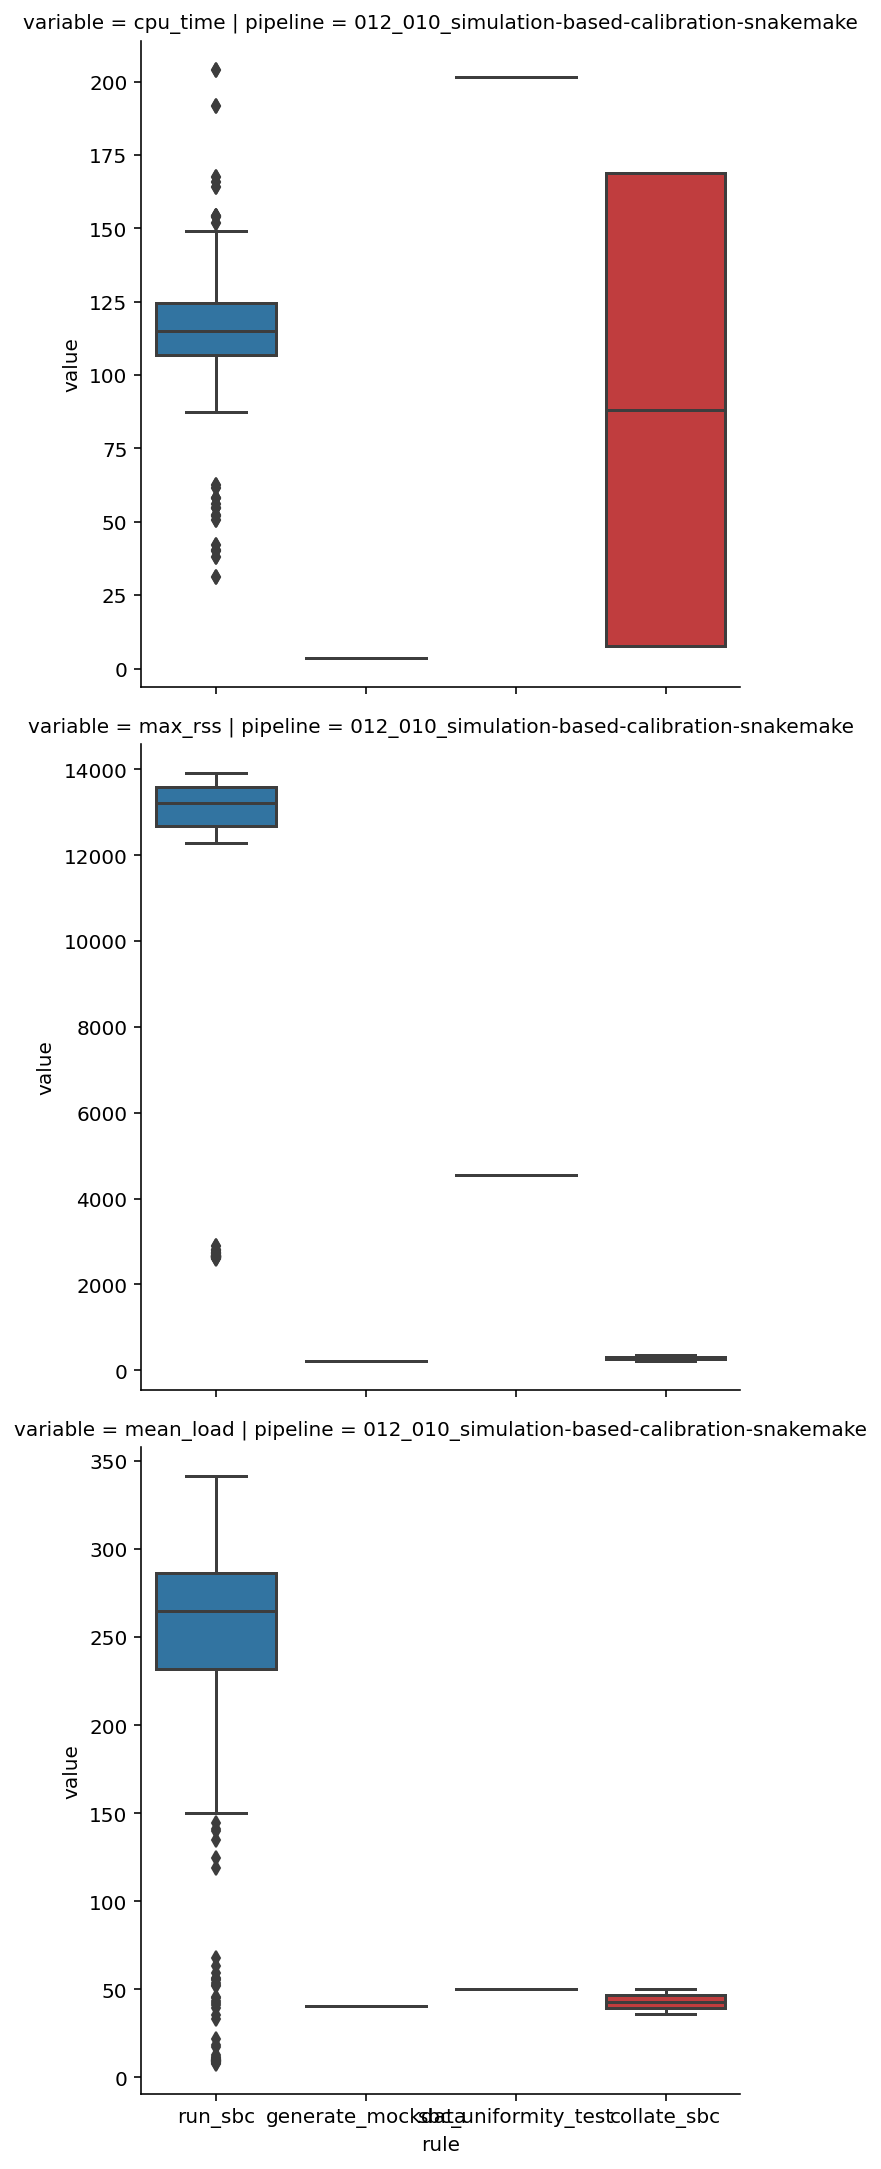

In [7]:
sns.catplot(
    data=benchmark_df_long,
    x="rule",
    y="value",
    kind="box",
    row="variable",
    col="pipeline",
    sharey=False,
);

---

In [8]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-07-27

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.25.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-167.o2.rc.hms.harvard.edu

Git branch: sbc-uniform-check

plotnine: 0.8.0
janitor : 0.21.0
pandas  : 1.3.0
seaborn : 0.11.1

